<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

# Fiche CC2 : Application du principe de stationnarité à des bases Yahoo Finance

## Importation de packages

In [1]:
import yfinance as yf
import numpy as np
import scipy as sp
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, kpss, acf, acovf, pacf


from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tools.eval_measures import rmse, meanabs

import seaborn as sns
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

## Importation des données

In [2]:
tickers = ['NVDA','AAPL']
data = yf.download(tickers, start="2024-01-01", end="2024-11-27") 

    # Cette instruction permet d'avoir les dates en index plutot que le simple numéro d'observation
    
data = yf.download(tickers, start="2023-01-01", end="2023-12-31")["Adj Close"]

# Renommer les colonnes
# nouveaux_noms = {"AAPL": "Apple", "MSFT": "Microsoft", "GOOG": "Alphabet"}
# data.rename(columns=nouveaux_noms, inplace=True)

nouveaux_noms = {"NVDA": "Nvidia","AAPL": "Apple"}
data.rename(columns= nouveaux_noms, inplace = True)

data.index = pd.to_datetime(data.index)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [3]:
    # Histoire de visualiser la base

print(data.head())

    # Histoire de savoir les noms des différentes colonnes
    
print(data.columns)


Ticker           Apple     Nvidia
Date                             
2023-01-03  123.768456  14.304595
2023-01-04  125.045044  14.738280
2023-01-05  123.718979  14.254632
2023-01-06  128.271103  14.848200
2023-01-09  128.795578  15.616640
Index(['Apple', 'Nvidia'], dtype='object', name='Ticker')


In [4]:
    # Création d'une série avec juste les close ajustés sur lesquels on va travailler
douns = data[['Apple']]

    # Histoire de visualiser la base
    
print(douns.head())

    # Histoire de savoir le nombre d'observation

print(douns.shape)

Ticker           Apple
Date                  
2023-01-03  123.768456
2023-01-04  125.045044
2023-01-05  123.718979
2023-01-06  128.271103
2023-01-09  128.795578
(250, 1)


In [5]:
    # Histoire de savoir les noms des différentes colonnes
print(douns.columns)

Index(['Apple'], dtype='object', name='Ticker')


<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

## Graphiques

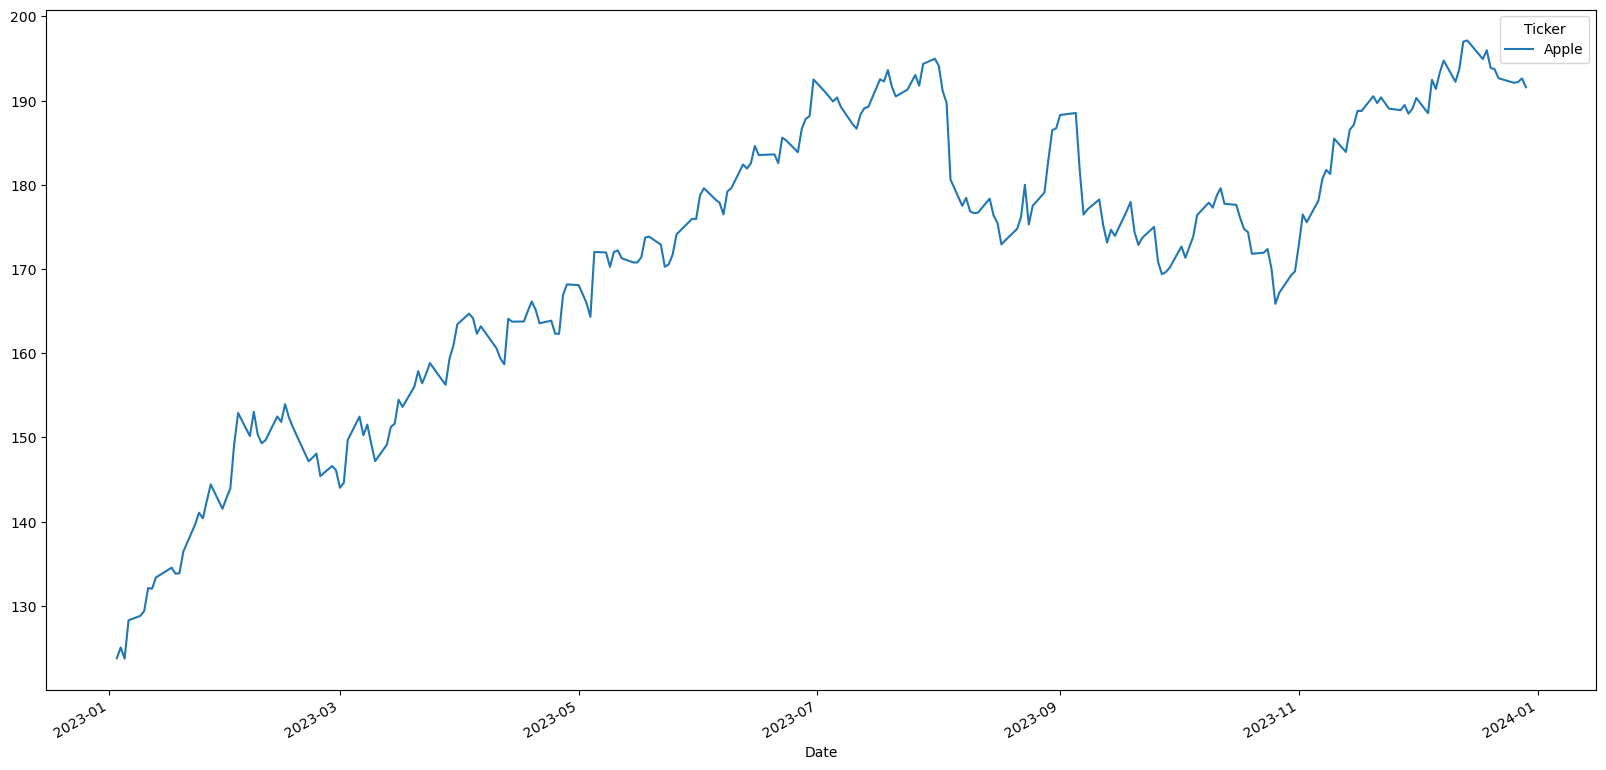

In [6]:
# graphique 1
plt.rcParams['figure.figsize'] = (20,10)
douns.plot()
plt.show()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

Graphique d'évolution du NIVEAU de prix de l'actif Nvidia. On constate que la série ne semble pas stationnaire : plusieurs tendances locales, la variance et la moyenne ne semblent pas constante dans le temps, une structure visibelement autocorrélée, on peut pensé à  une marche aléatoire.

In [9]:
    # Création d'un dataframe douns_2 a partir des close ajustée de douns 

douns_2 = douns[[('Adj Close')]]

    # Histoire de visualiser la base

douns_2.head()

KeyError: "None of [Index(['Adj Close'], dtype='object', name='Ticker')] are in the [columns]"

In [ ]:
    # Graphique du corrélogramme
    # Choix de la taille du graphique, généralement on touche pas trop

plt.rcParams['figure.figsize'] = (20,10)

    # Dans lags on  met chiffre de sorte a le moment où l'autocorrelation s'annule

plot_acf(douns_2[('Adj Close')], lags=30)

    # Affichage du graphique

plt.show()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

Autocorrélogramme : permet de voir la structure autorégressive (de long terme) des séries   
    
On soupçonne de la grosse autocorrélation. Ici on peut voir (à peu près) un processus autoregressif d'ordre 18 ce qui signifie que ce qui se passe aujourd'hui est influencer par les 18 périodes antérieur, ici on travaille sur une action donc 18 jours

In [ ]:
    # Pareil pour le graphique d'autocorrélation partielle

plt.rcParams['figure.figsize'] = (20,10)

plot_pacf(douns_2[('Adj Close')], lags=30)
plt.show()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
Autocorrélations partielles : permet de voir l'autocorrélation entre deux périodes après avoir purgé l'effet des autres périodes
    
Il mesure le degré d'autocorrélation. On ne prend jamais en compte le premier point qui représente le processus autoregressif d'ordre 0. Cela confirme l'idée de marche aléatoire puisque lorsque l'on retire l'effet des autres périodes, la seule autocorrélation partielle significative est celle à l'ordre 1. 

In [ ]:
    # Importation du package nécessaire pour faire un test ADF 

from statsmodels.tsa.stattools import adfuller

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

## Procédure du Test ADF
    
   - $H_0$ : la série est non-stationnaire, c a d qu'elle contient au moins une racine unitaire
   - $H_1$ : la série est stationnaire, c a d qu'elle ne comporte pas de racine unitaire

Ainsi, contrairement aux règles de décisions habituelles pour les tests bilatéraux, la règle est inversée :

   - $stat_{test} < stat_{table}$ on ne rejette pas $H_0$ : la tendance/constante n'est pas significativement différente de 0 (non-stationnaire)
    
   - $stat_{test} > stat_{table}$ on rejette $H_0$: la tendance/constante est pas significativement différente de 0 (stationnaire)

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>



- Valeurs critiques de la constante et de la tendance dans le test de Dickey-Fuller

<table>
    <col width="50">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <col width="70">
    <tr>
        <td colspan="1" style="text-align: center;border-right: 2px solid black"></td>
        <td colspan="3" style="text-align: center;border-right: 2px solid black"><i>Modèle [2]</i></td>
        <td colspan="6" style="text-align: center;border-right: 2px solid black"><i>Modèle [3]</i></td>
    </tr>
    <tr>
        <td colspan="1" style="text-align: center;border-right: 2px solid black"></td>
        <td colspan="3" style="text-align: center;border-right: 2px solid black">Constante</td>
        <td colspan="3" style="text-align: center;border-right: 2px solid black">Constante</td>
        <td colspan="3" style="text-align: center;border-right: 2px solid black">Trend</td>
    </tr>
    <tr style="text-align: center;border-bottom: 2px solid black">
        <td style="text-align: center;border-right: 2px solid black">T</td>
        <td style="text-align: center;border-right: 2px dotted black">1%</td>
        <td style="text-align: center;border-right: 2px dotted black">5%</td>
        <td style="text-align: center;border-right: 2px solid black">10%</td>
        <td style="text-align: center;border-right: 2px dotted black">1%</td>
        <td style="text-align: center;border-right: 2px dotted black">5%</td>
        <td style="text-align: center;border-right: 2px solid black">10%</td>
        <td style="text-align: center;border-right: 2px dotted black">1%</td>
        <td style="text-align: center;border-right: 2px dotted black">5%</td>
        <td style="text-align: center;border-right: 2px solid black">10%</td>
    </tr>
    <tr>
        <td style="text-align: center;border-right: 2px solid black">100</td>
        <td style="text-align: center;border-right: 2px dotted black">3.22</td>
        <td style="text-align: center;border-right: 2px dotted black">2.54</td>
        <td style="text-align: center;border-right: 2px solid black">2.17</td>
        <td style="text-align: center;border-right: 2px dotted black">3.78</td>
        <td style="text-align: center;border-right: 2px dotted black">3.11</td>
        <td style="text-align: center;border-right: 2px solid black">2.73</td>
        <td style="text-align: center;border-right: 2px dotted black">3.53</td>
        <td style="text-align: center;border-right: 2px dotted black">2.79</td>
        <td style="text-align: center;border-right: 2px solid black">2.38</td>
    </tr>
    <tr>
        <td style="text-align: center;border-right: 2px solid black">250</td>
        <td style="text-align: center;border-right: 2px dotted black">3.19</td>
        <td style="text-align: center;border-right: 2px dotted black">2.53</td>
        <td style="text-align: center;border-right: 2px solid black">2.16</td>
        <td style="text-align: center;border-right: 2px dotted black">3.74</td>
        <td style="text-align: center;border-right: 2px dotted black">3.09</td>
        <td style="text-align: center;border-right: 2px solid black">2.73</td>
        <td style="text-align: center;border-right: 2px dotted black">3.49</td>
        <td style="text-align: center;border-right: 2px dotted black">2.79</td>
        <td style="text-align: center;border-right: 2px solid black">2.38</td>
    </tr>
    <tr>
        <td style="text-align: center;border-right: 2px solid black">500</td>
        <td style="text-align: center;border-right: 2px dotted black">3.18</td>
        <td style="text-align: center;border-right: 2px dotted black">2.52</td>
        <td style="text-align: center;border-right: 2px solid black">2.16</td>
        <td style="text-align: center;border-right: 2px dotted black">3.72</td>
        <td style="text-align: center;border-right: 2px dotted black">3.08</td>
        <td style="text-align: center;border-right: 2px solid black">2.72</td>
        <td style="text-align: center;border-right: 2px dotted black">3.48</td>
        <td style="text-align: center;border-right: 2px dotted black">2.78</td>
        <td style="text-align: center;border-right: 2px solid black">2.38</td>
    </tr>
    <tr>
        <td style="text-align: center;border-right: 2px solid black">$\infty$</td>
        <td style="text-align: center;border-right: 2px dotted black">3.18</td>
        <td style="text-align: center;border-right: 2px dotted black">2.52</td>
        <td style="text-align: center;border-right: 2px solid black">2.16</td>
        <td style="text-align: center;border-right: 2px dotted black">3.71</td>
        <td style="text-align: center;border-right: 2px dotted black">3.08</td>
        <td style="text-align: center;border-right: 2px solid black">2.72</td>
        <td style="text-align: center;border-right: 2px dotted black">3.46</td>
        <td style="text-align: center;border-right: 2px dotted black">2.78</td>
        <td style="text-align: center;border-right: 2px solid black">2.38</td>
    </tr>
</table>
</span>

In [ ]:
    # Modèle constante & tendance 'ct'

adf1 = adfuller(douns_2[('Adj Close')], regression='ct', autolag='AIC', regresults=True)

    # Affichage des résultats
    
adf1[3].resols.summary()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test} = 2.183 < stat_{table}=2.79$ on ne rejette pas $H_0$ : la tendance n'est pas significativement différente de 0 (non-stationnaire)

In [ ]:
    # Modèle constante 'c'
    
adf1 = adfuller(douns_2[('Adj Close')], regression='c', autolag='AIC', regresults=True)

    # Affichage des résultats

adf1[3].resols.summary()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test} = 2.225 < stat_{table}=2.53$ on ne rejette pas $H_0$ : la constante n'est pas significativement différente de 0 (non-stationnaire)

In [ ]:
    # Modèle sans constante ni tendance 'n'

adf1 = adfuller(douns_2[('Adj Close')], regression='n', autolag='AIC', regresults=True)

    # Affichage des résultats

adf1

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test_1chiffre} = 1.322 > stat_{table}=-1.942$ on ne rejette pas $H_0$ la série est non stationnaire de type stochastique

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>

## Transformation de la variable et vérification de stationnarité

In [ ]:
    # taux de croissance de NVDA

douns_2["rNVDA"] = 100 * ( douns_2[('Adj Close')]/douns_2[('Adj Close')].shift(1) - 1 )

    # on enlève les NA
douns_2 = douns_2.dropna()

    # Affichage de la base 

print(douns_2.head())

    # Histoire de connaitre les nom des colonnes 
    
print(douns_2.columns)

In [ ]:
    # Modèle constante & tendance 'ct'

adf1 = adfuller(douns_2[('rNVDA')], regression='ct', autolag='AIC', regresults=True)

    # Affichage des résultats

adf1[3].resols.summary()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test} = -1.184 < stat_{table}=2.79$ on ne rejette pas $H_0$ : la tendance n'est pas significativement différente de 0 (non-stationnaire)

In [ ]:
    # Modèle constante 'c'

adf1 = adfuller(douns_2[('rNVDA')], regression='c', autolag='AIC', regresults=True)

    # Affichage des résultats

adf1[3].resols.summary()

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test} = 2.088 < stat_{table}=2.53$ on ne rejette pas $H_0$ : la tendance n'est pas significativement différente de 0 (non-stationnaire)

In [ ]:
adf1 = adfuller(douns_2[('rNVDA')], regression='n', autolag='AIC', regresults=True)
adf1

<span style='line-height:1.5;font-size: 17px;font-family:"Times New Roman"'>
$stat_{test_1chiffre} = -16.036 < stat_{table}=-1.942$ on rejette  $H_0$ : la tendance est significativement différente de 0 (stationnaire). La série est non stationnaire, elle est intégré d'ordre 1

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
douns_2[['rNVDA']].plot()
plt.show()
douns_2.head()

# ---------------------------ON S'ARRETE LA POUR LE CC2----------------------------------

In [ ]:
douns

In [ ]:
rNVDA = douns_2[['rNVDA']]
rNVDA.head()

In [ ]:
adf_stat, pvaleur, crit, regres = adfuller(rNVDA, regression="n", regresults=True) # maxlag
pvaleur # => série stationnaire

In [ ]:
plot_acf(rNVDA,  alpha=.05)
plt.show()

In [ ]:
coef_ac, confid_int = acf(rNVDA, nlags=10, alpha=.05)
coef_ac

In [ ]:
confid_int

 donc AR1

In [ ]:
for q, element in enumerate(coef_ac):
    if confid_int[q, 0] <= 0 <= confid_int[q, 1]:
        print(q-1)
        break

In [ ]:
plot_pacf(rNVDA,  alpha=.05)
plt.show()

In [ ]:
coef_pac, confid_int_pac = pacf(rNVDA, nlags=10, alpha=.05)

for p, element in enumerate(coef_pac):
    if confid_int_pac[p, 0] <= 0 <= confid_int_pac[p, 1]:
        print(p-1)
        break

Donc q = 1 et p = 1. On doit estimer les modèles suivant

- MA(1)
- AR(1)
- ARMA(1,1)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Convertir la colonne de date et définir l'index
douns_2['date_column'] = pd.to_datetime(douns_2['date_column'])
douns_2.set_index('date_column', inplace=True)
douns_2 = douns_2.asfreq('D')  # Définir la fréquence

In [ ]:
print(douns_2.columns)

In [ ]:
douns_2[['rNVDA']] = rNVDA
result_dict = {}
for p in [0,1]:
    for q in [0,1]:
        if (p != 0 or q != 0):
            arma_mod = ARIMA(endog=douns_2[['rNVDA']].dropna(), order=(p,0, q))
            fitx = arma_mod.fit()
            result_dict["ARMA_%s%s" % (p, q)] = fitx

In [ ]:
result_dict

In [ ]:
result_dict['ARMA_01'].summary()

In [ ]:
result_dict['ARMA_11'].summary()

In [ ]:
result_dict['ARMA_10'].summary()

In [ ]:
pvs = result_dict['ARMA_01'].pvalues
pvs

In [ ]:
pvs = result_dict['ARMA_10'].pvalues
pvs

In [ ]:
pvs = result_dict['ARMA_11'].pvalues
pvs

In [ ]:
def all_params_sign(pvs, seuil):
    for i, pv in enumerate(pvs):
        if pv > seuil:
            return False
    return True

In [ ]:
all_params_sign(pvs, 0.05)

In [ ]:
def which_is_unsign(pvs, seuil):
    res = []
    for i, pv in enumerate(pvs):
        if pv > seuil:
            res.append(pvs.index[i])
    return res

In [ ]:
which_is_unsign(pvs, 0.001)

In [ ]:
# probleme de significativité des coefficients
for k in result_dict.keys():
    pvs = result_dict[k].pvalues
    if not all_params_sign(pvs, 0.05):
        print(k, " => ", which_is_unsign(pvs, 0.05))

On retire de la liste le modèle suivant ARMA(1,1)

In [ ]:
result_dict.pop('ARMA_11', None)

In [ ]:
result_dict

In [ ]:
douns_2 = douns_2['rNVDA']

In [ ]:
def mape(y_estim, y):
    T = len(y)
    pct = (y - y_estim) / y
    return 100*(1/T)*sum(pct)

In [ ]:
for k in result_dict.keys():
    result = result_dict[k]
    # ddof
    ddof = len(result.params)
    residuals = result.resid
    acorr = acorr_ljungbox(residuals, model_df=ddof, lags=10, return_df=False) 
    het = het_arch(residuals, nlags=10, ddof=ddof)
    
    aic = result.aic
    bic = result.bic
    
    rmsex = rmse(result.fittedvalues, douns_2)
    maex  = meanabs(result.fittedvalues, douns_2)
    mapex = mape(result.fittedvalues, douns_2)
    print("%s --- pval_ljung: %.4f      --- pval_arch: %.4f" %(k, acorr.iloc[-1,1], het[1]))
    print("        --- AIC:       %.4f   --- BIC:      %.4f" % (aic, bic))
    print("        --- RMSE:       %.6f    --- MAE:       %.6f      --- MAPE: %.6f" % (rmsex, maex, mapex))
    print("-------------------------------------------------------------------------------------------")


In [ ]:
result_dict["ARMA_10"].forecast(steps=1, alpha=.05)

In [ ]:
resultat = result_dict["ARMA_10"]
resultat.summary()

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()
ax = douns_2.iloc[-1000:].plot(ax=ax)
fig = plot_predict(resultat,"9-2024", "11-2024", dynamic=True, ax=ax,
                        plot_insample=False)
fig, ax = plt.subplots()
ax = douns_2.iloc[-100:].plot(ax=ax)
fig = plot_predict(resultat,"9-2024", "11-2024", dynamic=True, ax=ax,
                        plot_insample=False)

fig, ax = plt.subplots()
ax = douns_2.iloc[-50:].plot(ax=ax)
fig = plot_predict(resultat,"9-2024", "11-2024", dynamic=True, ax=ax,
                        plot_insample=False)